<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Estimating Baseline Performance

### What is a baseline model? 

Producing a baseline model is crucial for evaluating your model's performance on any machine learning problem. A baseline model is a basic solution that serves as a point of reference for comparing other models to. The baseline model's performance gives us an indication of how much better our models can perform relative to a naive approach. 

### What are good baselines for sentence similarity?

For sentence similarity problems, we have to first produce a vector representation of each sentence in the sentence pair, known as an **embedding**. Then, we need to compute the similarity between these two sentence embeddings (we'll use Cosine Similarity).

For producing representations of sentences, there are some common baseline approaches: 
1. Create word embeddings for each word in a sentence using word2vec
2. Create sentence embeddings using TF-IDF

# Table of Contents
* [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
    * [Load STS Benchmark Dataset](#Load-STS-Benchmark-Dataset)
    - [Preprocess / Tokenize](#Data-Preprocessing-/-Tokenization)
    - [Document Frequency Calculation](#Document-Frequency-Calculation)
* [Baseline Models](#Baseline-Models)
    - [Baseline #1: word2vec and cosine similarity](#Baseline-#1:-Word2vec-Embeddings-with-Cosine-Similarity)
    * [Baseline #2: TF-IDF and cosine similarity](#Baseline-#2:-TF-IDF-Embeddings-with-Cosine-Similarity)

* [Comparison of Baseline Models](#Comparison-of-Baseline-Models)

In [1]:
#Import Packages
import sys
# Set the environment path
sys.path.append("../../")  
import os
from collections import Counter
import math
import numpy as np
from tempfile import TemporaryDirectory
import scrapbook as sb
import scipy
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

#Import utility functions
from utils_nlp.dataset import stsbenchmark
from utils_nlp.dataset.preprocess import (
    to_lowercase,
    to_spacy_tokens,
    rm_spacy_stopwords,
)
from utils_nlp.models.pretrained_embeddings import word2vec
from utils_nlp.models.pretrained_embeddings import fasttext

print("System version: {}".format(sys.version))

System version: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Set the path where you datasets are located
tmp_dir = TemporaryDirectory()
BASE_DATA_PATH = tmp_dir.name 

In [3]:
# Download pretrained word vectors
word2vec_model = word2vec.load_pretrained_vectors(dir_path=BASE_DATA_PATH)

100%|████████████████████████████████████████████████████████████████████████████| 1.61M/1.61M [03:25<00:00, 7.84kKB/s]


# Data Loading and Preprocessing

### Load STS Benchmark Dataset

Here we utilize the [STS Benchmark dataset](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark#STS_benchmark_dataset_and_companion_dataset) which contains a selection of English datasets that were used in Semantic Textual Similarity (STS) tasks 2012-2017. The datasets include text from image captions, news headlines, and user forums. The dataset contains 8,628 sentence pairs with a human-labeled integer representing the sentences' similarity (ranging from 0, for no meaning overlap, to 5, meaning equivalence).

In [4]:
# Produce a pandas dataframe for the training and test sets
train_raw = stsbenchmark.load_pandas_df(BASE_DATA_PATH, file_split="train").iloc[:3000,:]
test_raw = stsbenchmark.load_pandas_df(BASE_DATA_PATH, file_split="test")

# Clean the sts dataset
sts_train = stsbenchmark.clean_sts(train_raw)
sts_test = stsbenchmark.clean_sts(test_raw)

100%|██████████████████████████████████████████████████████████████████████████████████| 401/401 [00:02<00:00, 194KB/s]


Data downloaded to C:\Users\cocochra\AppData\Local\Temp\tmpfes56btj\raw\stsbenchmark


100%|██████████████████████████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 212KB/s]


Data downloaded to C:\Users\cocochra\AppData\Local\Temp\tmpfes56btj\raw\stsbenchmark


In [5]:
print("Training set has {} sentences".format(len(sts_train)))
print("Testing set has {} sentences".format(len(sts_test)))

Training set has 3000 sentences
Testing set has 1379 sentences


In [6]:
sts_test.head(10)

,score,sentence1,sentence2
0,2.500,A girl is styling her hair.,A girl is brushing her hair.
1,3.600,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.000,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.200,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.500,A man is playing a harp.,A man is playing a keyboard.
5,1.800,A woman is cutting onions.,A woman is cutting tofu.
6,3.500,A man is riding an electric bicycle.,A man is riding a bicycle.
7,2.200,A man is playing the drums.,A man is playing the guitar.
8,2.200,A man is playing guitar.,A lady is playing the guitar.
9,1.714,A man is playing a guitar.,A man is playing a trumpet.


### Data Preprocessing / Tokenization

Our baseline models will expect that each sentence is represented by a list of **tokens**. Tokens are linguistic units like words, punctuation marks, numbers, etc. We'll use our util functions which utilize the spaCy package, a popular package for performing tokenization.

It's also common to remove high-frequency words which do not help distinguish one sentence from another, so called **stop words**. For example, "the", "and", "a", etc. are typical stop words although each tokenization package may differ in the words they consider to be stop words. We'll tokenize our corpus with and without stop words so that we can compare our methods with and without stop words.

#### Training Set Preprocessing

In [7]:
# Convert all text to lowercase
df_low = to_lowercase(sts_train)  
# Tokenize text
sts_tokenize = to_spacy_tokens(df_low) 
# Tokenize with removal of stopwords
sts_train_stop = rm_spacy_stopwords(sts_tokenize) 

Now each row in our dataframe contains:  
- The similarity score of the sentence pair
- The 2 original sentences from our datasets  
- A column for each sentence's tokenization with stop words  
- A column for each sentence's tokenization without stop words

In [8]:
sts_train_stop.head(5)

,score,sentence1,sentence2,sentence1_tokens,sentence2_tokens,sentence1_tokens_rm_stopwords,sentence2_tokens_rm_stopwords
0,5.00,a plane is taking off.,an air plane is taking off.,"[a, plane, is, taking, off, .]","[an, air, plane, is, taking, off, .]","[plane, taking, .]","[air, plane, taking, .]"
1,3.80,a man is playing a large flute.,a man is playing a flute.,"[a, man, is, playing, a, large, flute, .]","[a, man, is, playing, a, flute, .]","[man, playing, large, flute, .]","[man, playing, flute, .]"
2,3.80,a man is spreading shreded cheese on a pizza.,a man is spreading shredded cheese on an uncoo...,"[a, man, is, spreading, shreded, cheese, on, a...","[a, man, is, spreading, shredded, cheese, on, ...","[man, spreading, shreded, cheese, pizza, .]","[man, spreading, shredded, cheese, uncooked, p..."
3,2.60,three men are playing chess.,two men are playing chess.,"[three, men, are, playing, chess, .]","[two, men, are, playing, chess, .]","[men, playing, chess, .]","[men, playing, chess, .]"
4,4.25,a man is playing the cello.,a man seated is playing the cello.,"[a, man, is, playing, the, cello, .]","[a, man, seated, is, playing, the, cello, .]","[man, playing, cello, .]","[man, seated, playing, cello, .]"


#### Test Set Preprocessing

In [9]:
# Convert all text to lowercase
df_low = to_lowercase(sts_test)
# Tokenize text
sts_tokenize = to_spacy_tokens(df_low)
# Tokenize with removal of stopwords
sts_test_stop = rm_spacy_stopwords(sts_tokenize)

### Document Frequency Calculation

Many baseline models we explore will require calculation of how frequently a word appears in our corpus. To calculate this, we iterate through the sentences in our training set and count the number of sentences that contain each word. Note that "document" refers to some larger chunk of multiple tokens/words. In our case, our documents will actually be individual sentences. 

In [10]:
def get_document_frequency(df):
    """Iterate through all sentences in dataframe and create a dictionary 
    mapping tokens to the number of sentences in our corpus they appear in
    
    Args:
        df (pandas dataframe): dataframe of sentence pairs with their similarity scores
        
    Returns:
        document_frequency_dict (dictionary): mapping from tokens to number of sentences they appear in
        n (int): number of sentences in the corpus
    """
    document_frequency_dict = {}
    all_sentences =  df[["sentence1_tokens", "sentence2_tokens"]]
    sentences = all_sentences.values.flatten().tolist()
    n = len(sentences)

    for s in sentences:
        for token in set(s):
            document_frequency_dict[token] = document_frequency_dict.get(token, 0) + 1

    return document_frequency_dict, n

In [11]:
# Note that we need to calculate these values on our training set so that we don't "peek at" our test set until test time
document_frequencies, num_documents = get_document_frequency(sts_train_stop)

In [12]:
num_documents

6000

# Baseline Models

As we consider each of the baseline models, we'll save all model predictions in a dictionary and will evaluate the results at the end of this notebook.

In [13]:
baselines = {}

## Baseline #1: Word2vec Embeddings with Cosine Similarity

This baseline first constructs word embeddings using word2vec. Once we have a word embedding (vector) for each word in the sentence, we calculate an embedding for the full sentence by taking the (weighted) average of all the word embeddings. The weights will be calculated using TF-IDF. Lastly, in order to compare the two sentence embeddings we use the cosine similarity metric. 

### What is Word2Vec?
Word2vec is a predictive model for learning word embeddings from text (see [original research paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)). Word embeddings are learned such that words that share common contexts in the corpus will be close together in the vector space. There are two different model architectures that can be used to produce word2vec embeddings: continuous bag-of-words (CBOW) or continuous skip-gram. The former uses a window of surrounding words (the "context") to predict the current word and the latter uses the current word to predict the surrounding context words. See this [tutorial](https://www.guru99.com/word-embedding-word2vec.html#3) on word2vec for more detailed information about the model.

For our purposes, we use pretrained word2vec word embeddings. These embeddings were trained on a Google News corpus and provide 300-dimensional embeddings (vectors) for 3 million English words. See this [link](https://code.google.com/archive/p/word2vec/) for the original location of the embeddings and see the code below to load these word embeddings.

### What is TF-IDF?

TF-IDF or term frequency-inverse document frequency is a weighting scheme intended to measure how important a word is to the document (or sentence in our case) within the broader corpus (our dataset). The weight "increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus" ([tutorial link](http://www.tfidf.com/)). When we're averaging together many different word vectors to get a sentence embedding, it makes sense to give stronger weights to words that are more distinct relative to the corpus and that have a high frequency in the sentence. The TF-IDF weights capture this intution, with the weight increasing as term frequency increases and/or as the inverse document frequency increases.

For a term $t$ in sentence $s$ in corpus $c$, then the TF-IDF weight is 
$$w_{t,s} = TF_{t,s} * \log{\frac{N}{df_t}}$$
where:  
$TF_{t,s}$ = the number of times term $t$ appears in sentence $s$  
$df_t$ = the number of sentences containing term $t$  
$N$ = the size of the corpus.  

In these baselines, we calculate the TF-IDF weighted average of all the word embeddings. The code below implements this weighted average given a list of tokens and an embedding model.

In [14]:
def average_sentence_embedding(tokens, embedding_model):
    """Calculate TF-IDF weighted average embedding for a sentence
    
    Args:
        tokens (list): list of tokens in a sentence
        embedding_model: model to use for word embedding (word2vec, glove, fastText, etc.)
    
    Returns:
        list: vector representing the sentence
    """
    # Throw away tokens that are not in the embedding model
    tokens = [i for i in tokens if i in embedding_model]

    if len(tokens) == 0:
        return []

    # We will weight by TF-IDF. The TF part is calculated by:
    # (# of times term appears / total terms in sentence)
    count = Counter(tokens)
    token_list = list(count)
    term_frequency = [count[i] / len(tokens) for i in token_list]

    # Now for the IDF part: LOG(# documents / # documents with term in it)
    inv_doc_frequency = [
        math.log(num_documents / (document_frequencies.get(i, 0) + 1)) for i in count
    ]

    # Put the TF-IDF together and produce the weighted average of vector embeddings
    word_embeddings = [embedding_model[token] for token in token_list]
    weights = [term_frequency[i] * inv_doc_frequency[i] for i in range(len(token_list))]
    return list(np.average(word_embeddings, weights=weights, axis=0))

### What is Cosine Similarity?

Cosine similarity is a common similarity metric between vectors. Intuitively it measures the cosine of the angle between any two vectors. With vectors $a$ and $b$, the cosine similarity is: cosine similarity($a$,$b$) = $\frac{\vec{a} \cdot \vec{b} }{||\vec{a}|| ||\vec{b}||}$


In [15]:
def calculate_cosine_similarity(embedding1, embedding2):
    """Calculate cosine similarity between two embedding vectors
    
    Args:
        embedding1 (list): embedding for the first sentence
        embedding2 (list): embedding for the second sentence
    
    Returns:
        list: cosine similarity value between the two embeddings
    """
    # distance.cosine calculates cosine DISTANCE, so we need to
    # return 1 - distance to get cosine similarity
    cosine_similarity = 1 - distance.cosine(embedding1, embedding2)
    return cosine_similarity

### Get Sentence Similarity Predictions for Test Set

Now, we calculate predictions for each sentence pair found in the test set.

In [16]:
def average_word_embedding_cosine_similarity(df, embedding_model, rm_stopwords=False):
    """Calculate the cosine similarity between TF-IDF weighted averaged embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        embedding_model: word embedding model
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    if rm_stopwords:
        df['sentence1_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence1_tokens_rm_stopwords, embedding_model), axis=1)
        df['sentence2_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence2_tokens_rm_stopwords, embedding_model), axis=1)
    else:
        df['sentence1_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence1_tokens, embedding_model), axis=1)
        df['sentence2_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence2_tokens, embedding_model), axis=1)

    df['predictions'] = df.apply(lambda x: calculate_cosine_similarity(x.sentence1_embedding, x.sentence2_embedding) if 
                                 (sum(x.sentence1_embedding) != 0 and sum(x.sentence2_embedding) != 0) else 0, axis=1)
    
    return df['predictions'].tolist()

In [17]:
# Get predictions using average word2vec embeddings both with and without stop words
baselines["Word2vec Cosine"] = average_word_embedding_cosine_similarity(
    sts_test_stop, word2vec_model, rm_stopwords=True
)
baselines["Word2vec Cosine with Stop Words"] = average_word_embedding_cosine_similarity(
    sts_test_stop, word2vec_model, rm_stopwords=False
)

## Baseline #2: TF-IDF Embeddings with Cosine Similarity

This baseline first constructs a document embedding based on bag-of-words with TF-IDF weighting (for an introduction to TF-IDF, see [Background on TF-IDF](#What-is-TF-IDF?). Then we apply cosine similarity between the two embeddings in the sentence pair (for an introduction to the cosine similarity metric, see [Background on Cosine Similarity](#What-is-Cosine-Similarity?)).

### Bag-of-Words

The most basic approach for document embeddings is called Bag-of-Words. This method first determines the vocabulary across the entire corpus and then, for each document, creates a vector containing the number of times each vocabulary word appeared in the given document. These vectors are obviously very sparse and typical bag-of-words implementations ignore terms whose document frequency is less than some threshold in order to reduce sparsity. We also often ignore stop words as they add little semantic information. 

In [18]:
def tfidf_cosine_similarity(df, rm_stopwords=False):
    """Calculate cosine similarity between TF-IDF document embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
    stop_word_param = "english" if rm_stopwords else None

    tf = TfidfVectorizer(
        input="content",
        analyzer="word",
        min_df=0,
        stop_words=stop_word_param,
        sublinear_tf=True,
    )
    all_sentences = df[["sentence1", "sentence2"]]
    corpus = np.concatenate([df["sentence1"].values, df["sentence2"].values])
    tfidf_matrix = np.array(tf.fit_transform(corpus).todense())
    num_samples = len(df.index)
    
    # calculate the cosine similarity between pairs of tfidf embeddings
    # first pair at index 0 and n in tfidf_matrix, second pair at 1 and n+1, etc.
    df["predictions"] = df.apply(
        lambda x: calculate_cosine_similarity(
            tfidf_matrix[int(x.name), :], tfidf_matrix[num_samples + int(x.name), :]
        )
        if (
            sum(tfidf_matrix[int(x.name), :]) != 0
            and sum(tfidf_matrix[num_samples + int(x.name), :]) != 0
        )
        else 0,
        axis=1,
    )
    return df["predictions"].tolist()

In [19]:
baselines["TF-IDF Cosine"] = tfidf_cosine_similarity(sts_test_stop, rm_stopwords=True)
baselines["TF-IDF Cosine with Stop Words"] = tfidf_cosine_similarity(
    sts_test_stop, rm_stopwords=False
)

# Comparison of Baseline Models

Our evaluation metric is Pearson correlation ($\rho$) which is a measure of the linear correlation between two variables. The formula for calculating Pearson correlation is as follows:  

$$\rho_{X,Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$$

This metric takes a value in [-1,1] where -1 represents a perfect negative correlation, 1 represents a perfect positive correlation, and 0 represents no correlation. We utilize the Pearson correlation metric as this is the metric that [SentEval](http://nlpprogress.com/english/semantic_textual_similarity.html), a widely-used evaluation toolkit for evaluation sentence representations, uses for the STS Benchmark dataset.

In [20]:
def pearson_correlation(df, prediction):
    """Calculate the Pearson correlation between two vectors
    
    Args:
        df (pandas dataframe): dataframe of sentences and their similarity scores
        prediction (list): predicted similarity scores for each value in test set
        
    Returns:
        float: pearson correlation value between the actual and predicted score lists
    """
    pearson_correlation = scipy.stats.pearsonr(prediction, list(df["score"]))[0]
    return pearson_correlation

In [21]:
# Get metrics on predictions from all models
results = dict((model, pearson_correlation(sts_test_stop, baselines[model])) for model in baselines)
results

{'Word2vec Cosine': 0.6426925655137739,
 'Word2vec Cosine with Stop Words': 0.6675501552751987,
 'TF-IDF Cosine': 0.6749213786510484,
 'TF-IDF Cosine with Stop Words': 0.7118087132257669}

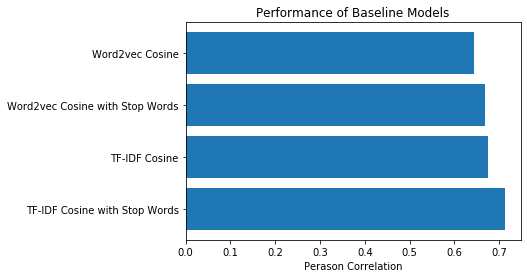

In [22]:
fig, ax = plt.subplots()

# Example data
x = list(baselines.keys())
x_pos = np.arange(len(x))
y = list(results.values())

ax.barh(x_pos, y, align='center')
ax.set_yticks(x_pos)
ax.set_yticklabels(x)
ax.invert_yaxis() 
ax.set_xlabel('Perason Correlation')
ax.set_title('Performance of Baseline Models')

plt.show()

In [23]:
# Clean up data
tmp_dir.cleanup()

In [24]:
# Record results with scrapbook for tests
sb.glue("results", results)